<a href="https://colab.research.google.com/github/swilsonmfc/nlp/blob/master/ALBERT_DistilBERT_MobileBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Smaller Transformers

![](https://eazybi.com/static/img/blog/posts/2015_12_14/small_vs_big.jpg)

# Install

In [1]:
!pip install transformers
!pip install datasets

     |████████████████████████████████| 4.0 MB 5.1 MB/s 
     |████████████████████████████████| 77 kB 7.9 MB/s 
     |████████████████████████████████| 596 kB 68.2 MB/s 
     |████████████████████████████████| 6.6 MB 51.6 MB/s 
     |████████████████████████████████| 895 kB 52.7 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 325 kB 5.1 MB/s 
     |████████████████████████████████| 212 kB 32.6 MB/s 
     |████████████████████████████████| 136 kB 69.5 MB/s 
     |████████████████████████████████| 1.1 MB 66.8 MB/s 
     |████████████████████████████████| 127 kB 74.8 MB/s 
     |████████████████████████████████| 271 kB 68.3 MB/s 
     |████████████████████████████████| 144 kB 71.3 MB/s 
     |████████████████████████████████| 94 kB 4.0 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib

# Setup

In [2]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import Trainer
from transformers import TrainingArguments
from transformers import pipeline

from datasets import load_dataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support

# Data
* FakeNews
* Dataset has 6 labels
* Pre-Processing
  * Not multi-modal training
  * Collapse this into 2 labels
  * Concatenate several text fields

In [3]:
liar = load_dataset("liar")

Using custom data configuration default


Generating train split:   0%|          | 0/10269 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1283 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1284 [00:00<?, ? examples/s]

Dataset liar downloaded and prepared to /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
liar

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [6]:
liar['train'][1]

{'barely_true_counts': 0.0,
 'context': 'a floor speech.',
 'false_counts': 0.0,
 'half_true_counts': 1.0,
 'id': '10540.json',
 'job_title': 'State delegate',
 'label': 1,
 'mostly_true_counts': 1.0,
 'pants_on_fire_counts': 0.0,
 'party_affiliation': 'democrat',
 'speaker': 'scott-surovell',
 'state_info': 'Virginia',
 'statement': 'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
 'subject': 'energy,history,job-accomplishments'}

## Pre-Processing
* Concatenate fields

In [5]:
# Combine text fields
for ds in ['train', 'test', 'validation']:
  text = []
  for statement, subject, context, speaker in zip(liar[ds]['statement'],
                                                  liar[ds]['subject'],
                                                  liar[ds]['context'],
                                                  liar[ds]['speaker']):
    text.append(statement + ' ' + subject + ' ' + context + ' ' + speaker)
  liar[ds] = liar[ds].add_column('text', text)

## Condense Labels

In [6]:
# Labels
# 'False', 'Half-True', 'Mostly-True', 'True', 'Barely-True', 'Pants-on-Fire'
for ds in ['train', 'test', 'validation']:
  binary = []
  for label in liar[ds]['label']:
    # False, Barely-True and Pants-on-Fire
    if label == 0 or label == 4 or label == 5:
      label = 0
    else:
      label = 1
    binary.append(label)
  liar[ds] = liar[ds].remove_columns('label')
  liar[ds] = liar[ds].add_column('label', binary)

In [8]:
LABELS = 2

## Sample

In [7]:
liar['train']

Dataset({
    features: ['id', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', 'text', 'label'],
    num_rows: 10269
})

# Results

In [9]:
def metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [10]:
results_df = pd.DataFrame(columns=['Accuracy', 'F1', 'Precision', 'Recall', 'Parameters', 'Time'])

# BERT - Base
* BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
* https://arxiv.org/pdf/1810.04805
* Devlin 2018

In [11]:
model_name = "bert-base-cased"

## Tokenize

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [13]:
def tokenize(batch):
    return tokenizer(batch['statement'], padding=True, truncation=True)
liar_enc = liar.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Model

In [14]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=LABELS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

## Train

In [15]:
BATCH_SIZE = 64
logging_steps = len(liar_enc['train']) // BATCH_SIZE
training_args = TrainingArguments(output_dir="results-bert",
                                  num_train_epochs=10,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  disable_tqdm=False)

In [16]:
%%time
start = time.time()
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=liar_enc['train'],
                  eval_dataset=liar_enc['validation'])
trainer.train();
end = time.time();

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10269
  Num Epochs = 10
  Instant

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.682779,0.571651,0.521393,0.598505,0.571651
2,No log,0.655538,0.620717,0.603306,0.634642,0.620717
3,No log,0.671111,0.613707,0.598775,0.623330,0.613707
4,0.641600,0.695146,0.620717,0.609210,0.628058,0.620717
5,0.641600,0.736353,0.613707,0.604976,0.617614,0.613707
6,0.641600,0.761793,0.612150,0.608762,0.612314,0.612150
7,0.491800,0.800653,0.612150,0.608276,0.612565,0.612150
8,0.491800,0.848165,0.616822,0.606377,0.622588,0.616822
9,0.491800,0.858147,0.612928,0.604084,0.616846,0.612928
10,0.361900,0.861524,0.608255,0.602747,0.609419,0.608255


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 64
Saving model checkpoint to results-bert/checkpoint-161
Configuration saved in results-bert/checkpoint-161/config.json
Model weights saved in results-bert/checkpoint-161/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and

CPU times: user 24min 48s, sys: 4min 55s, total: 29min 44s
Wall time: 30min 10s


## Test

In [18]:
preds = trainer.predict(liar_enc['test'])
results_df.loc['BERT-base'] = [preds.metrics['test_accuracy'],
                                   preds.metrics['test_f1'],
                                   preds.metrics['test_precision'],
                                   preds.metrics['test_recall'],
                                   sum(p.numel() for p in model.parameters() if p.requires_grad),
                                   (end - start)]
preds.metrics

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1283
  Batch size = 64


{'test_accuracy': 0.6367887763055339,
 'test_f1': 0.6189225503579843,
 'test_loss': 0.6653920412063599,
 'test_precision': 0.6345483702810439,
 'test_recall': 0.6367887763055339,
 'test_runtime': 6.5254,
 'test_samples_per_second': 196.616,
 'test_steps_per_second': 3.218}

# BERT - Small
* Well-Read Students Learn Better: On the Importance of Pre-training Compact Models
* https://arxiv.org/pdf/1908.08962
* Turc 2019

## Pre-Training Compact Models

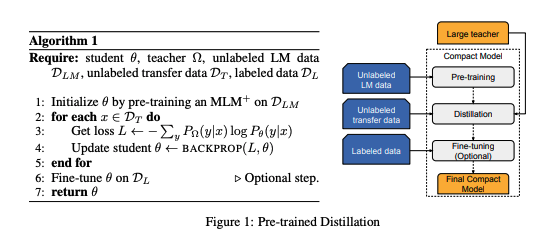

## Layer & Hidden Size Reduction

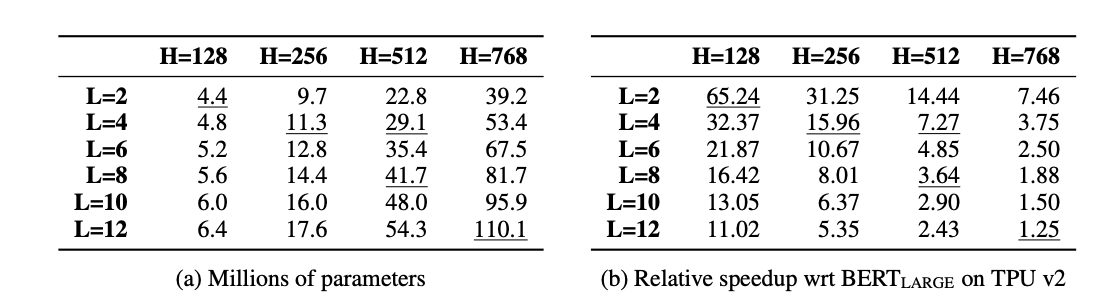

In [19]:
model_name = "prajjwal1/bert-small"

## Tokenizer

In [20]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading file https://huggingface.co/prajjwal1/bert

In [21]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)
liar_enc = liar.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-22ef07e523a0caec.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-a537623bc3884fef.arrow


## Model

In [22]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=LABELS)

loading configuration file https://huggingface.co/prajjwal1/bert-small/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/ac031779e2b4dd1d9da1e39c9d6a29fd45deea195eb3703a701d9c77f60abb4e.1257bb8f1f585038e86954d2560e36ca5c2dd98a8cde30fd22468940c911b672
Model config BertConfig {
  "_name_or_path": "prajjwal1/bert-small",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 2048,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 8,
  "num_hidden_layers": 4,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.18.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

loading weights file https://huggingface.co/prajjwal1/bert-small/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transfor

## Train

In [23]:
BATCH_SIZE = 64
logging_steps = len(liar_enc['train']) // BATCH_SIZE
training_args = TrainingArguments(output_dir="results-bert",
                                  num_train_epochs=10,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  disable_tqdm=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [24]:
%%time
start = time.time()
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=liar_enc['train'],
                  eval_dataset=liar_enc['validation'])
trainer.train();
end = time.time();

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10269
  Num Epochs = 10
  Instant

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.652741,0.609813,0.594602,0.618948,0.609813
2,No log,0.637205,0.630062,0.624424,0.632702,0.630062
3,No log,0.631760,0.630841,0.630935,0.631106,0.630841
4,0.649900,0.628282,0.639408,0.638892,0.639030,0.639408
5,0.649900,0.632036,0.641745,0.636911,0.644374,0.641745
6,0.649900,0.628303,0.644860,0.644726,0.647608,0.644860
7,0.600800,0.630468,0.644081,0.642092,0.644310,0.644081
8,0.600800,0.633381,0.640187,0.636822,0.641364,0.640187
9,0.600800,0.630523,0.651869,0.651621,0.651601,0.651869
10,0.571300,0.631696,0.647975,0.647540,0.647638,0.647975


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 64
Saving model checkpoint to results-bert/checkpoint-161
Configuration saved in results-bert/checkpoint-161/config.json
Model weights saved in results-bert/checkpoint-161/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and

CPU times: user 5min 50s, sys: 6.67 s, total: 5min 57s
Wall time: 6min 5s


## Test

In [25]:
preds = trainer.predict(liar_enc['test'])
results_df.loc['BERT-small'] = [preds.metrics['test_accuracy'],
                                   preds.metrics['test_f1'],
                                   preds.metrics['test_precision'],
                                   preds.metrics['test_recall'],
                                   sum(p.numel() for p in model.parameters() if p.requires_grad),
                                   (end - start)]
preds.metrics

The following columns in the test set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1283
  Batch size = 64


{'test_accuracy': 0.6414653156664069,
 'test_f1': 0.6416133203439095,
 'test_loss': 0.6348366737365723,
 'test_precision': 0.6417737584323937,
 'test_recall': 0.6414653156664069,
 'test_runtime': 1.3634,
 'test_samples_per_second': 941.059,
 'test_steps_per_second': 15.403}

# ALBERT
* ALBERT: A Lite BERT for Self-supervised Learning of Language Representations
* https://arxiv.org/pdf/1909.11942
* Lan 2019

## Cross-Layer Parameter Sharing

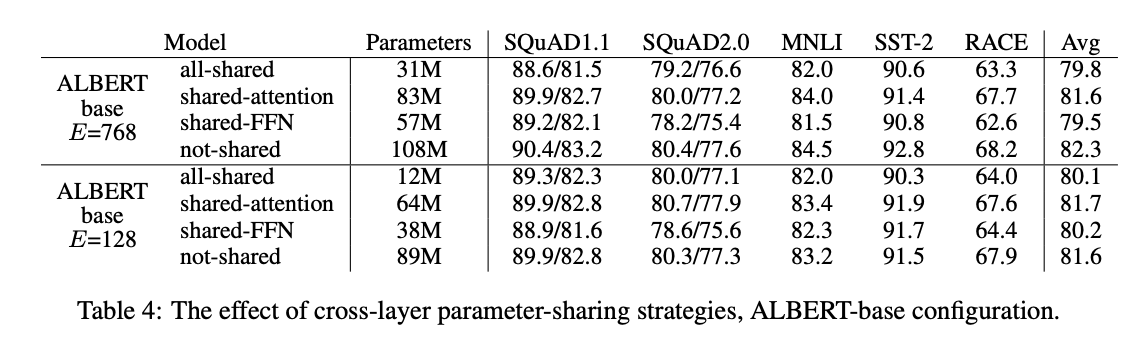

## Factorize Embedding Layer

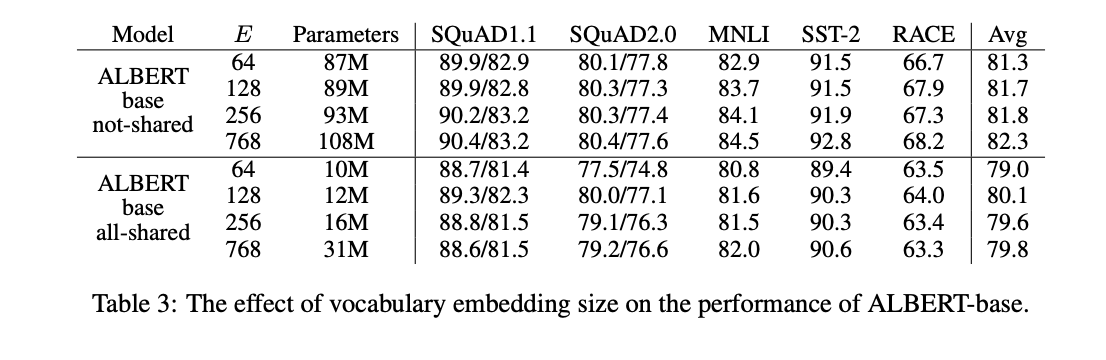

## Sentence Order Prediction

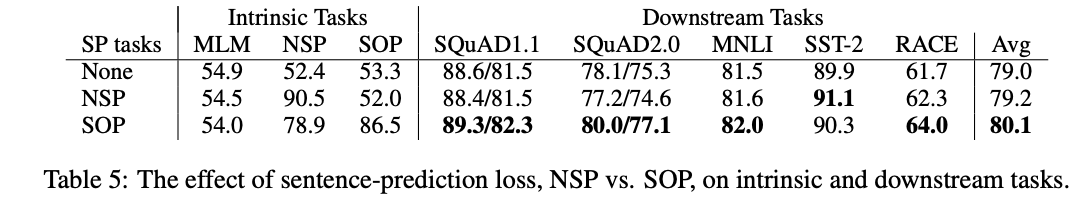

## Comparison to BERT
* 9x fewer parameters (compared to BERT base)
* 18x fewer parameters (compared to BERT large)
* Training time improvement (1.7x)
* Inference time (no change)

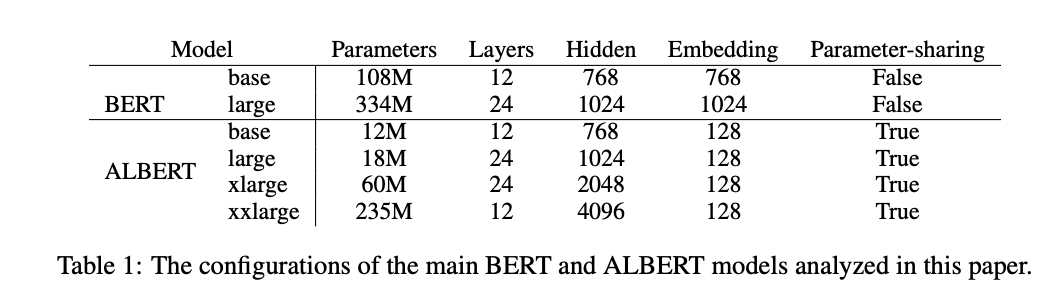

In [55]:
model_name = "albert-base-v2"

## Tokenizer

In [56]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hid

In [57]:
def tokenize(batch):
    return tokenizer(batch['statement'], padding=True, truncation=True)
liar_enc = liar.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-4462d6997aeab10d.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-0646a38213e3df4b.arrow


## Model

In [58]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=LABELS)

loading configuration file https://huggingface.co/albert-base-v2/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/e48be00f755a5f765e36a32885e8d6a573081df3321c9e19428d12abadf7dba2.b8f28145885741cf994c0e8a97b724f6c974460c297002145e48e511d2496e88
Model config AlbertConfig {
  "_name_or_path": "albert-base-v2",
  "architectures": [
    "AlbertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0,
  "bos_token_id": 2,
  "classifier_dropout_prob": 0.1,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_id": 3,
  "gap_size": 0,
  "hidden_act": "gelu_new",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_memory_blocks": 0,
  "pad_token_id": 0,
  "position_embedding_type": 

## Train

In [59]:
BATCH_SIZE = 64
logging_steps = len(liar_enc['train']) // BATCH_SIZE
training_args = TrainingArguments(output_dir="results-albert",
                                  num_train_epochs=10,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  disable_tqdm=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [62]:
%%time
start = time.time()
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=liar_enc['train'],
                  eval_dataset=liar_enc['validation'])
trainer.train();
end = time.time()

The following columns in the training set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10269
  Num Epochs = 10
  Ins

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,1.029608,0.604361,0.593576,0.608819,0.604361
2,No log,1.299372,0.590343,0.575041,0.595934,0.590343
3,No log,1.457524,0.595794,0.594421,0.595085,0.595794
4,0.172300,1.675240,0.585670,0.584740,0.584949,0.585670
5,0.172300,2.069984,0.594237,0.588839,0.594565,0.594237
6,0.172300,2.333049,0.591900,0.588211,0.591504,0.591900
7,0.038900,2.457271,0.595016,0.592602,0.594390,0.595016
8,0.038900,2.549145,0.584891,0.581573,0.584190,0.584891
9,0.038900,2.602179,0.583333,0.580241,0.582553,0.583333
10,0.006600,2.613416,0.583333,0.577945,0.583101,0.583333


The following columns in the evaluation set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 64
Saving model checkpoint to results-albert/checkpoint-161
Configuration saved in results-albert/checkpoint-161/config.json
Model weights saved in results-albert/checkpoint-161/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `AlbertForSequenceClassification.

CPU times: user 25min, sys: 6min 42s, total: 31min 42s
Wall time: 31min 44s


## Test

In [63]:
preds = trainer.predict(liar_enc['test'])
results_df.loc['ALBERT'] = [preds.metrics['test_accuracy'],
                                   preds.metrics['test_f1'],
                                   preds.metrics['test_precision'],
                                   preds.metrics['test_recall'],
                                   sum(p.numel() for p in model.parameters() if p.requires_grad),
                                   (end - start)]
preds.metrics

The following columns in the test set  don't have a corresponding argument in `AlbertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `AlbertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1283
  Batch size = 64


{'test_accuracy': 0.5946999220576773,
 'test_f1': 0.5935203643007908,
 'test_loss': 1.5069891214370728,
 'test_precision': 0.5927548247817834,
 'test_recall': 0.5946999220576773,
 'test_runtime': 5.7348,
 'test_samples_per_second': 223.721,
 'test_steps_per_second': 3.662}

# DistilBERT
* DistilBERT, a distilled version of BERT: smaller, faster, cheaper and lighter
* https://arxiv.org/pdf/1910.01108
* Sanh 2019
* https://towardsdatascience.com/distillation-of-bert-like-models-the-theory-32e19a02641f

## Student Initialization

![](https://miro.medium.com/max/1400/1*9kE4oa0M3io2hd58LiwYgw.png)

## Distillation
* Combine three losses:
  * Loss on the specific problem (classification & MLM)
  * Cross entropy loss between student and teacher (student distribution should be like teacher)
  * Cosine loss (Student and teacher should have similar vectors)

![](https://miro.medium.com/max/1400/1*v-O4GGBJiCf1PAtgcV4f4w.png)

## Softmax Temperature
* Soften softmax (higher values move towards uniform)
* Temperature used only at training

![](https://miro.medium.com/max/1400/1*oRqw7kWld7qvdkkQjvsyzQ.png)

In [48]:
model_name = "distilbert-base-uncased"

## Tokenizer

In [49]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10

In [50]:
def tokenize(batch):
    return tokenizer(batch['statement'], padding=True, truncation=True)
liar_enc = liar.map(tokenize, batched=True, batch_size=None)

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-8cd245cd767498ea.arrow


  0%|          | 0/1 [00:00<?, ?ba/s]

Loading cached processed dataset at /root/.cache/huggingface/datasets/liar/default/1.0.0/479463e757b7991eed50ffa7504d7788d6218631a484442e2098dabbf3b44514/cache-03f2f14bb42c384c.arrow


## Model

In [51]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=LABELS)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.18.0",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

## Train

In [52]:
BATCH_SIZE = 64
logging_steps = len(liar_enc['train']) // BATCH_SIZE
training_args = TrainingArguments(output_dir="results-distilbert",
                                  num_train_epochs=10,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  disable_tqdm=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [53]:
%%time
start = time.time()
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=liar_enc['train'],
                  eval_dataset=liar_enc['validation'])
trainer.train();
end = time.time();

The following columns in the training set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10269
  Num Epochs = 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,0.661922,0.606698,0.599198,0.609031,0.606698
2,No log,0.649562,0.620717,0.616222,0.621895,0.620717
3,No log,0.649423,0.632399,0.627577,0.634460,0.632399
4,0.631200,0.659046,0.629283,0.628826,0.628885,0.629283
5,0.631200,0.700738,0.629283,0.622462,0.632963,0.629283
6,0.631200,0.708844,0.623832,0.621910,0.623620,0.623832
7,0.516900,0.737917,0.622274,0.621682,0.621817,0.622274
8,0.516900,0.800185,0.603583,0.593516,0.607413,0.603583
9,0.516900,0.797173,0.626947,0.623745,0.627511,0.626947
10,0.414700,0.802337,0.623053,0.620411,0.623165,0.623053


The following columns in the evaluation set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 64
Saving model checkpoint to results-distilbert/checkpoint-161
Configuration saved in results-distilbert/checkpoint-161/config.json
Model weights saved in results-distilbert/checkpoint-161/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `DistilBertFo

CPU times: user 14min 48s, sys: 12.1 s, total: 15min
Wall time: 15min 14s


## Test

In [54]:
preds = trainer.predict(liar_enc['test'])
results_df.loc['DistilBERT'] = [preds.metrics['test_accuracy'],
                                   preds.metrics['test_f1'],
                                   preds.metrics['test_precision'],
                                   preds.metrics['test_recall'],
                                   sum(p.numel() for p in model.parameters() if p.requires_grad),
                                   (end - start)]
preds.metrics

The following columns in the test set  don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1283
  Batch size = 64


{'test_accuracy': 0.6492595479345284,
 'test_f1': 0.6487819179998047,
 'test_loss': 0.6522243618965149,
 'test_precision': 0.6484178741481205,
 'test_recall': 0.6492595479345284,
 'test_runtime': 2.9605,
 'test_samples_per_second': 433.371,
 'test_steps_per_second': 7.093}

# MobileBERT
* MobileBERT: a Compact Task-Agnostic BERT
for Resource-Limited Devices
* https://arxiv.org/pdf/2004.02984.pdf
* Sun et. al. 2020

## Architecture
* Main idea - rather than reduce the number of layers, keep them, but reduce the size of the hidden parameters

![](https://miro.medium.com/max/1553/1*YQEljpFAgOgVAaRnDNMF7Q.jpeg)


## Bottleneck & Inverted Bottleneck
* Step up the embedding to the correct size in the IB-BERT (Teacher) -- 512
* Step down the embedding to the desired size in the MobileBERT (Student) -- 128

## Distillation Losses
* Multi-Head Attention (MHA)
  * Self-attention is a key driver of performance in Trasnformers
  * Minimize the KL-Divergence between the per-head self-attention distributions 
* Feature Map Transfer (FMT)
  * Each layer takes the previous layer as input
  * The output between layers should be as close as possible (Between Teacher and Student)
* Pre-Training Distillation (PD)
  * Loss in Student MLM
  * KL-Divergence of Softmax (between Teacher and Student)
  * Loss in Student NSP

## Feed Forward Network
* MHA - Attend to different information
* FFN - Increase non-linearity
* MobileBERT the traditional FFN with a 4 layer FFN
* Goal is to align sizes and maintain the ratio between MHA and FFN

## Remove LayerNorm & Gelu
* Paper finds that LayerNorm and GeLU are significant processing steps
* Replaces LayerNorm with NoNorm
* Replaces GeLU with ReLU

In [40]:
model_name = 'google/mobilebert-uncased'

## Tokenizer

In [41]:
tokenizer = AutoTokenizer.from_pretrained(model_name)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
 

In [42]:
def tokenize(batch):
    return tokenizer(batch['statement'], padding=True, truncation=True)
liar_enc = liar.map(tokenize, batched=True, batch_size=None)

  0%|          | 0/1 [00:00<?, ?ba/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

## Model

In [43]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=LABELS)

loading configuration file https://huggingface.co/google/mobilebert-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/f55082bb509cfd3585c1d6e383f529197f03fce817374e4edf03306593ef4c16.8198c2ba6b951372d5ca981b940a059b96ebbb3c514469a2aae7636fa05eb25e
Model config MobileBertConfig {
  "_name_or_path": "google/mobilebert-uncased",
  "architectures": [
    "MobileBertForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_activation": false,
  "classifier_dropout": null,
  "embedding_size": 128,
  "hidden_act": "relu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 512,
  "initializer_range": 0.02,
  "intermediate_size": 512,
  "intra_bottleneck_size": 128,
  "key_query_shared_bottleneck": true,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "mobilebert",
  "normalization_type": "no_norm",
  "num_attention_heads": 4,
  "num_feedforward_networks": 4,
  "num_hidden_layers": 24,
  "pad_token_id": 0,
  "transforme

## Train

In [44]:
BATCH_SIZE = 64
logging_steps = len(liar_enc['train']) // BATCH_SIZE
training_args = TrainingArguments(output_dir="results-mobilebert",
                                  num_train_epochs=10,
                                  learning_rate=1e-5,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=BATCH_SIZE,
                                  load_best_model_at_end=True,
                                  metric_for_best_model="f1",
                                  weight_decay=0.01,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  disable_tqdm=False)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [45]:
%%time
start = time.time()
trainer = Trainer(model=model, 
                  args=training_args,
                  compute_metrics=metrics,
                  train_dataset=liar_enc['train'],
                  eval_dataset=liar_enc['validation'])
trainer.train();
end = time.time();

The following columns in the training set  don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 10269
  Num Epochs = 

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,No log,2885.996826,0.480530,0.312800,0.750589,0.480530
2,No log,1493.891602,0.520249,0.356072,0.270659,0.520249
3,No log,1141.111816,0.520249,0.356072,0.270659,0.520249
4,7978.713500,783.596558,0.482866,0.319278,0.664407,0.482866
5,7978.713500,74.913399,0.520249,0.356072,0.270659,0.520249
6,7978.713500,0.785023,0.481308,0.451697,0.465688,0.481308
7,377.469200,0.960670,0.494548,0.494239,0.494065,0.494548
8,377.469200,0.754197,0.528816,0.460911,0.528927,0.528816
9,377.469200,0.772828,0.522586,0.503337,0.517835,0.522586
10,0.874500,0.721662,0.534268,0.495199,0.533342,0.534268


The following columns in the evaluation set  don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1284
  Batch size = 64
Saving model checkpoint to results-mobilebert/checkpoint-161
Configuration saved in results-mobilebert/checkpoint-161/config.json
Model weights saved in results-mobilebert/checkpoint-161/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `MobileBertFo

CPU times: user 11min 17s, sys: 3min, total: 14min 18s
Wall time: 14min 20s


## Test

In [46]:
preds = trainer.predict(liar_enc['test'])
results_df.loc['MobileBERT'] = [preds.metrics['test_accuracy'],
                                   preds.metrics['test_f1'],
                                   preds.metrics['test_precision'],
                                   preds.metrics['test_recall'],
                                   sum(p.numel() for p in model.parameters() if p.requires_grad),
                                   (end - start)]
preds.metrics

The following columns in the test set  don't have a corresponding argument in `MobileBertForSequenceClassification.forward` and have been ignored: statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context. If statement, party_affiliation, half_true_counts, barely_true_counts, speaker, text, false_counts, id, pants_on_fire_counts, subject, mostly_true_counts, state_info, job_title, context are not expected by `MobileBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1283
  Batch size = 64


{'test_accuracy': 0.558846453624318,
 'test_f1': 0.538542530036041,
 'test_loss': 0.741661548614502,
 'test_precision': 0.5436822732834783,
 'test_recall': 0.558846453624318,
 'test_runtime': 2.2174,
 'test_samples_per_second': 578.603,
 'test_steps_per_second': 9.471}

# Pruning
* Are Sixteen Heads Really Better than One?
* https://arxiv.org/pdf/1905.10650.pdf
* Michel 2019


## Findings
* Models trained with multi-head attention, in practice, can have a percentage of them removed without affecting performance
* At test time, most heads are redundant given rest of the model and some layers can be reduced to a single attention head at test time


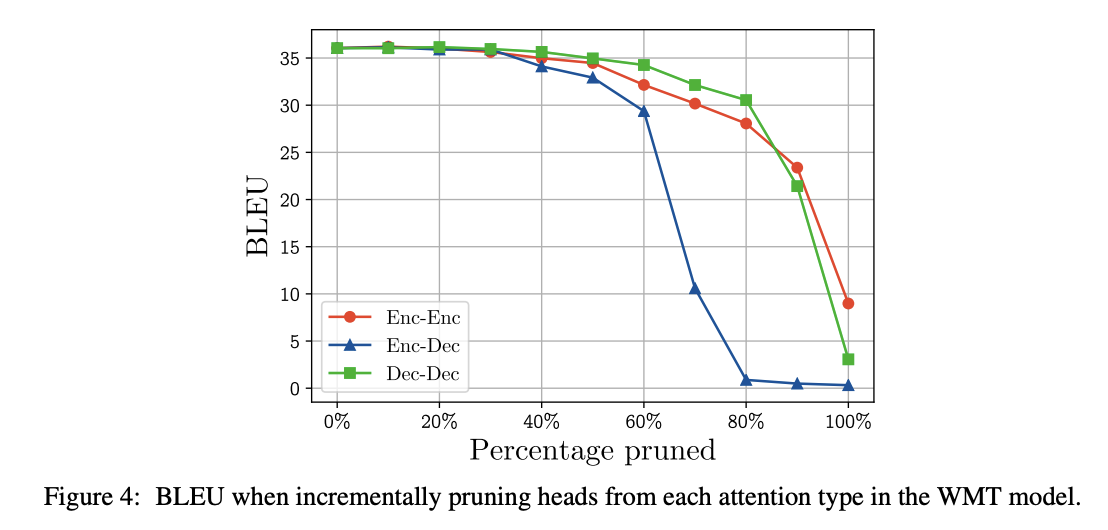

# Quantization
* Deep Learning with Limited Numerical Precision
* https://arxiv.org/pdf/1502.02551.pdf
* Gupta 2015

* Understanding and Overcoming the Challenges of Efficient Transformer Quantization
* https://arxiv.org/pdf/2109.12948.pdf
* Bondarenko 2021

* https://huggingface.co/docs/transformers/performance

* Main idea - use fewer bits to represent variables in model
* Similar to rounding / chopping precision
* Considered orthogonal to knowledge distillation (can be applied to any model)

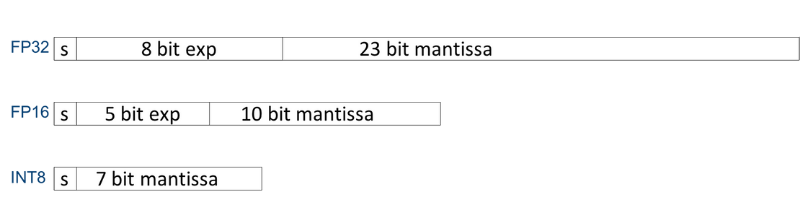

# Results

In [64]:
results_df

,Accuracy,F1,Precision,Recall,Parameters,Time
BERT-base,0.636789,0.618923,0.634548,0.636789,108311810.0,1810.111984
BERT-small,0.641465,0.641613,0.641774,0.641465,28764674.0,365.313801
ALBERT,0.594700,0.593520,0.592755,0.594700,11685122.0,1904.230870
DistilBERT,0.649260,0.648782,0.648418,0.649260,66955010.0,914.009918
MobileBERT,0.558846,0.538543,0.543682,0.558846,24582914.0,860.240867
